In [1]:
from matplotlib import pyplot as plt
from utils.utils import *
import utils.promethee_functions as pf
import utils.clustering_functions as cf
import utils.eval_metrics as em

utils.py Loading


In [ ]:
def K_Medoid_Eta(alternatives, distance_matrix, k=3, prototype_method="random", print_results=True, iter_max=100, seed=None):
    """ 
    K-Medoid clustering algorithm using the Aggregated Eta matrix
        - alternatives: np.array of the alternatives names only
        - distance_matrix: pd.DataFrame of the distance matrix with index and columns as the alternatives names
        - k: the number of clusters

    Returns:
        - the medoids of the clusters
        - the clusters
    """

    # Initialize medoids
    if prototype_method == "random":
        medoids = np.random.choice(alternatives, k, replace=False)
    
    elif prototype_method == "farthest":
        # Select the farthest alternatives from each other
        medoids = [alternatives[0]] # Start with the first alternative
        for _ in range(k-1):
            distances = [np.min([distance_matrix.loc[alternative, medoid] for medoid in medoids]) for alternative in alternatives]
            new_medoid = alternatives[np.argmax(distances)]
            medoids.append(new_medoid)
        medoids = np.array(medoids)
    
    elif prototype_method == "km++":
        # Select randomly the first medoid
        random_index = np.random.choice(len(alternatives))
        medoids = [alternatives[random_index]]
        for _ in range(k-1):
            distances = [np.min([distance_matrix.loc[alternative, medoid] for medoid in medoids]) for alternative in alternatives]
            new_medoid = alternatives[np.argmax(distances)]
            medoids.append(new_medoid)
        medoids = np.array(medoids)

    elif prototype_method == "seed":
        if seed:
            medoids = np.array(seed)
        else:
            raise ValueError("Seed medoids not provided")

    if print_results:
        print("Initial medoids:", medoids)

    # Initialize clusters
    clusters = {medoid: [] for medoid in medoids}

    # Initialize assignment check
    assigned = {alternative: False for alternative in alternatives}


    # When entering the loop, we just have the medoids and no assigned alternatives
    iter = 0
    converged = False
    while not converged and iter < iter_max:

        # Assign medoid to its cluster
        for medoid in medoids:
            clusters[medoid].append(medoid)
            assigned[medoid] = True


        # Assign each alternative to the closest medoid
        for alternative in alternatives:
            if not assigned[alternative]: # If not yet assigned, assign it to the closest medoid
                distances = [distance_matrix.loc[alternative, medoid] for medoid in medoids] # Take the distances to each medoid
                closest_medoid = medoids[np.argmin(distances)] # Take the medoid with the smallest distance
                clusters[closest_medoid].append(alternative) # Assign the alternative to the cluster of the closest medoid
                assigned[alternative] = True

        if print_results:
            print("Iteration", iter)
            print("Clusters:", clusters)
            print("Assigned:", all(assigned.values()))

        # Update medoids
        converged = True
        for medoid in medoids:
            cluster = clusters[medoid]

            # Compute the sum of the distance for each alternative in the cluster towards the other alternatives in the cluster
            distances = [np.sum([distance_matrix.loc[alternative, alternative2] for alternative2 in cluster]) for alternative in cluster]
            if len(distances) > 1:
                new_medoid = cluster[np.argmin(distances)] # Take the alternative with the smallest sum of distances
            else:
                new_medoid = medoid
            if new_medoid != medoid:
                # print("Medoid", medoid, "changed to", new_medoid, "in array", medoids)
                index = np.where(medoids == medoid)
                # print("Index:", index[0])
                medoids[index[0][0]] = new_medoid # Update the medoid in the list
                converged = False # If at least one medoid has changed, we have not converged
                clusters = {medoid: [] for medoid in medoids} # Reinitialize the cluster
                assigned = {alternative: False for alternative in alternatives} # Reinitialize the cluster assignment check
        iter += 1
    
    if iter_max == iter:
        if print_results:
            print("Max iterations reached, no convergence but assigning the alternatives to the closest last medoid computed:")
        for alternative in alternatives:
            if not assigned[alternative]:
                distances = [distance_matrix.loc[alternative, medoid] for medoid in medoids]
                closest_medoid = medoids[np.argmin(distances)]
                clusters[closest_medoid].append(alternative)

    return medoids, clusters, iter

In [3]:
def G_Kmedoid(data, W, P, Q, L, dist_matrix, Weight_vector, k=3, prototype_method="random"):
    """ 
    Function that receives the raw dataset and creates the clusters using the K-Medoid algorithm using Promethee Gamma as the distance matrix
    - data: pd.DataFrame with the raw dataset - iso3 as index and the criteria as columns names
    - W: list of weights for each criteria - must sum to 1
    - P: list of P thresholds for each criteria - must be > 0
    - Q: list of Q thresholds for each criteria - must be >= 0
    - Weight_vector: list of weights for each time point - must sum to 1
    - k: number of clusters to create
    """
    # Verify that the weights sum to 1
    if sum(W) != 1:
        raise ValueError("The weights must sum to 1")
    
    if len(W) != data.shape[1] or len(P) != data.shape[1] or len(Q) != data.shape[1]:
        raise ValueError("The number of weights, P and Q thresholds must be equal to the number of criteria")
    
    # Verify that the P thresholds are > 0
    if any([p <= 0 for p in P]):
        raise ValueError("The P thresholds must be > 0")
    
    # Verify that the Q thresholds are >= 0
    if any([q < 0 for q in Q]):
        raise ValueError("The Q thresholds must be >= 0")
    
    if sum(Weight_vector) != 1:
        raise ValueError("The time weight vector must sum to 1")
    
    if len(Weight_vector) != data.iloc[0]["co2prod"].shape[0]:
        raise ValueError("The time weight vector must have the same length as the time series")

    # Get the criteria names
    alternatives = data.index

    # # Computing the distance matrix
    # phi_c_all = pf.get_all_Phi_c(data, P, Q, L)
    # eta = pf.get_eta_matrix(data, phi_c_all, W, L)
    # agg_eta = pf.aggregate_all_series(eta, Weight_vector)
    # dist_matrix = pd.DataFrame(agg_eta, index=alternatives, columns=alternatives)

    # Run the K-Medoid algorithm
    medoids, clusters, iter = K_Medoid_Eta(alternatives, dist_matrix, k, prototype_method=prototype_method, print_results=False)

    cluster_list = [val for val in clusters.values()]

    # return medoids, clusters
    return cluster_list


In [13]:
def test_diff_seeds_GKM(data, P, Q, L, W, alternatives, Weight_vector, k=3, nb_try=10):
    """ 
    Function that tests the Gamma-Kmedoids algorithm with the different seeds in order to evaluate the stability of the clustering
    """
    # Computing the distance matrix
    phi_c_all = pf.get_all_Phi_c(data, P, Q, L)
    eta = pf.get_eta_matrix(data, phi_c_all, W, L)
    agg_eta = pf.aggregate_all_series(eta, Weight_vector)
    dist_matrix = pd.DataFrame(agg_eta, index=alternatives, columns=alternatives)


    random_dunn_gkm = []
    farthest_dunn_gkm = []
    kmplus_dunn_gkm = []
    for i in tqdm(range(nb_try), desc="Random initialization"):
        results = G_Kmedoid(data, W, P, Q, L, dist_matrix, Weight_vector, k=k, prototype_method="random")
        random_dunn_gkm.append(em.dunn_index_multivariate(results, data))

    for i in tqdm(range(nb_try), desc="Farthest initialization"):
        results = G_Kmedoid(data, W, P, Q, L, dist_matrix, Weight_vector, k=k, prototype_method="farthest")
        farthest_dunn_gkm.append(em.dunn_index_multivariate(results, data))

    for i in tqdm(range(nb_try), desc="Km++ initialization"):
        results = G_Kmedoid(data, W, P, Q, L, dist_matrix, Weight_vector, k=k, prototype_method="km++")
        kmplus_dunn_gkm.append(em.dunn_index_multivariate(results, data))

    return random_dunn_gkm, farthest_dunn_gkm, kmplus_dunn_gkm

def analyze_results(dunn1, dunn2, dunn3):
    """
    Analyze the results of the clustering algorithms
    """
    dunn1 = np.array(dunn1)
    dunn2 = np.array(dunn2)
    dunn3 = np.array(dunn3)

    # Plot boxplots for each algorithm (on the same plot)
    plt.figure(figsize=(10, 6))

    plt.boxplot([dunn1, dunn2, dunn3], tick_labels=["Random", "Farthest", "Km++"])
    plt.title("Analysis of Dunn index for different initialization methods of the G-Kmedoids algorithm")
    plt.show()


In [7]:
data = read_data()
# Nb of criteria
K = data.columns.shape[0] # Nb of criteria
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series

W = [1/K for i in range(K)] # Weights of the criteria (equal weights)
Q = [1, 0.03, 5, 0.01, 0.5, 0.5] # Indifference thresholds
P = [10, 0.4, 20, 0.3, 5, 5]

Weight_vector = [1/L for _ in range(L)] # Equal weights times

Reading HDI dataset
co2prod: min=0.0, max=33.3863
hdi: min=0.257, max=0.967
le: min=37.105, max=85.473
gdi: min=0.383, max=1.041
eys: min=3.5751, max=23.2477
mys: min=1.4606, max=14.2559


c:\Users\raphu\Documents\ULB\MA2\ulb-master-thesis\code\src\utils\promethee_functions.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]
Km++ initialization: 100%|██████████| 50/50 [00:09<00:00,  5.17it/s]
C:\Users\raphu\AppData\Local\Temp\ipykernel_33560\932536913.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([dunn1, dunn2, dunn3], labels=["Random", "Farthest", "Km++"])


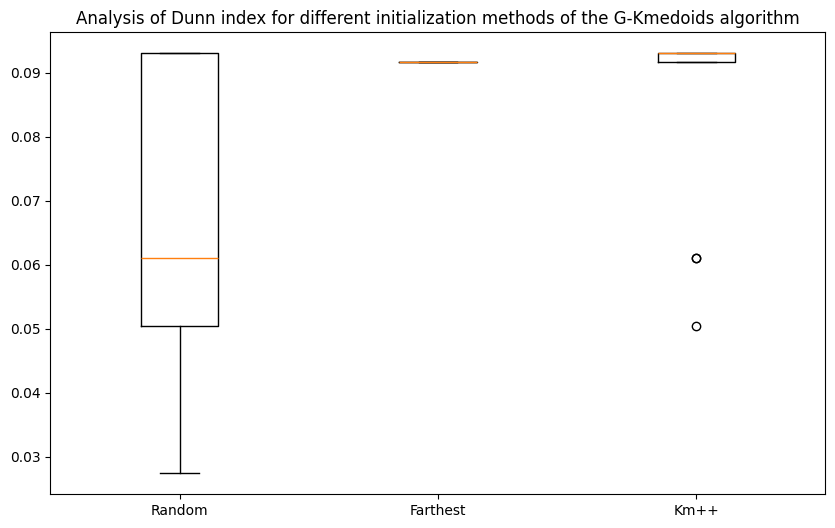

In [10]:
k = 5

dunn1, dunn2, dunn3 = test_diff_seeds_GKM(data, P, Q, L, W, data.index, Weight_vector, k=3, nb_try=50)
analyze_results(dunn1, dunn2, dunn3)

c:\Users\raphu\Documents\ULB\MA2\ulb-master-thesis\code\src\utils\promethee_functions.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]
Km++ initialization: 100%|██████████| 50/50 [00:10<00:00,  4.95it/s]
C:\Users\raphu\AppData\Local\Temp\ipykernel_33560\932536913.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([dunn1, dunn2, dunn3], labels=["Random", "Farthest", "Km++"])


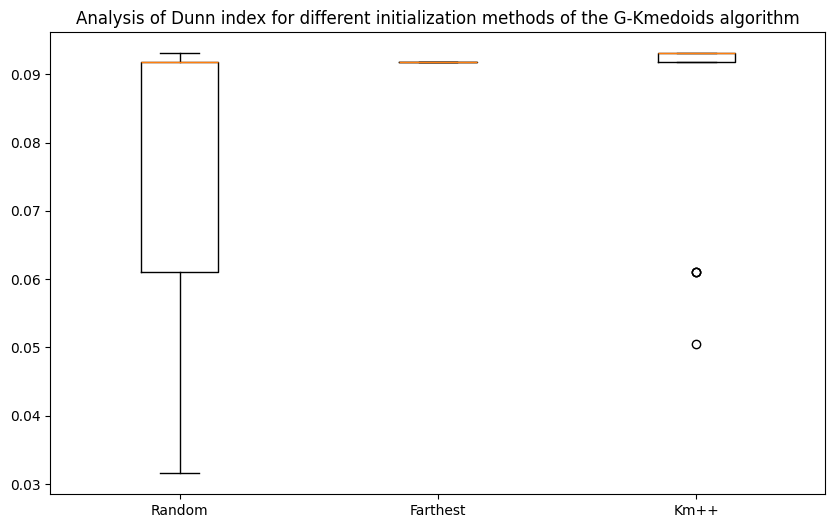

In [11]:
k = 10

dunn1, dunn2, dunn3 = test_diff_seeds_GKM(data, P, Q, L, W, data.index, Weight_vector, k=3, nb_try=50)
analyze_results(dunn1, dunn2, dunn3)

c:\Users\raphu\Documents\ULB\MA2\ulb-master-thesis\code\src\utils\promethee_functions.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]
Km++ initialization: 100%|██████████| 50/50 [00:00<00:00, 145.29it/s]
C:\Users\raphu\AppData\Local\Temp\ipykernel_33560\932536913.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([dunn1, dunn2, dunn3], labels=["Random", "Farthest", "Km++"])


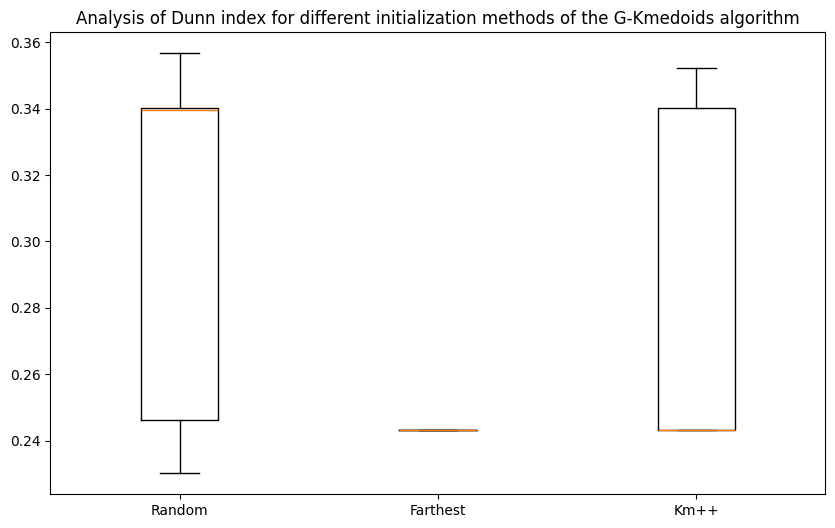

In [12]:
group0 = ["PAK", "SDN", "BDI", "HTI"]
group1 = ["EST", "CZE", "MLT", "SGP", "IRL"]
group2 = ["CHE", "ISL", "NZL", "SWE"]
all_groups = group0 + group1 + group2
data = data.loc[all_groups]
N = data.shape[0]

k = 3

dunn1, dunn2, dunn3 = test_diff_seeds_GKM(data, P, Q, L, W, data.index, Weight_vector, k=3, nb_try=50)
analyze_results(dunn1, dunn2, dunn3)